In [202]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  layers, Sequential, Input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
 
import os, shutil,cv2
import numpy as np
import pandas as pd
from types import SimpleNamespace
from matplotlib import pyplot as plt

In [181]:
conf = SimpleNamespace(
    root_dir = "/kaggle/input/brain-tumor-mri-dataset/",
    work_dir = "/kaggle/working/data/",
    train_dir = "/kaggle/working/data/train/",
    test_dir = "/kaggle/working/data/test/",
    val_dir = "/kaggle/working/data/val/",
)

train_conf = SimpleNamespace(
    img_shape = (384, 384),
    batch_size = 32,
    epochs = 10
)

Total files: 5712


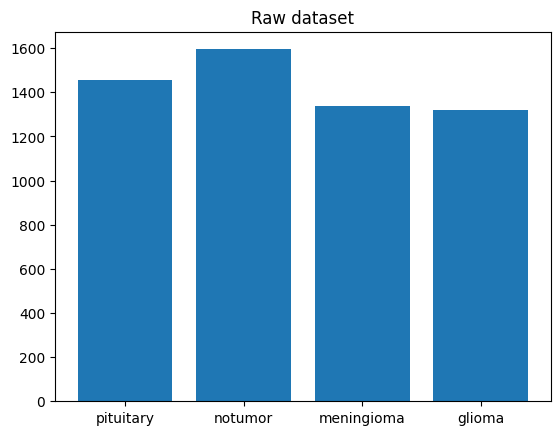

In [5]:
# EDA

def plot_catg_count(path, name=""):
    fc = 0
    cl_name = []
    cl_count = []
    for d in os.listdir(path):
        #print(f"{d} -- {len(os.listdir(train_path + d))}")
        cl_name.append(d)
        cl_count.append(len(os.listdir(path + d)))
        fc += len(os.listdir(path + d))

    print(f"Total files: {fc}")
    plt.bar(cl_name, cl_count)
    plt.title(name)
    

plot_catg_count(conf.root_dir + "Training/", name="Raw dataset")

In [6]:
# Make train, val and test set

def make_work_dir():
    os.makedirs(conf.work_dir, exist_ok=True)    
    os.makedirs(conf.train_dir, exist_ok=True)
    os.makedirs(conf.test_dir, exist_ok=True)
    os.makedirs(conf.val_dir, exist_ok=True)


def make_split(split_size=[0.7, 0.2, 0.1]):
    make_work_dir()
    
    raw_train_path = conf.root_dir + "Training/" 
    for d in os.listdir(raw_train_path):
        sub_dir = f"{raw_train_path}{d}/"
        files = os.listdir(sub_dir)
        file_count = len(files)
        
        for idx, fname in enumerate(files):
            if idx < int(file_count * split_size[0]):
                os.makedirs(f"{conf.train_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.train_dir}{d}/{fname}"
            elif idx < int(file_count * (split_size[0] + split_size[1])):
                os.makedirs(f"{conf.val_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.val_dir}{d}/{fname}"
            else:
                os.makedirs(f"{conf.test_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.test_dir}{d}/{fname}"
                
            f_curr_path = f"{sub_dir}{fname}"
            shutil.copyfile(f_curr_path, f_new_path)

# **Making Dataset**

In [7]:
make_split()

In [99]:
train_set = image_dataset_from_directory(
    conf.train_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

val_set = image_dataset_from_directory(
    conf.val_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

test_set = image_dataset_from_directory(
    conf.test_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

Found 3996 files belonging to 4 classes.
Found 1143 files belonging to 4 classes.
Found 573 files belonging to 4 classes.


Total files: 3996
Total files: 1143
Total files: 573


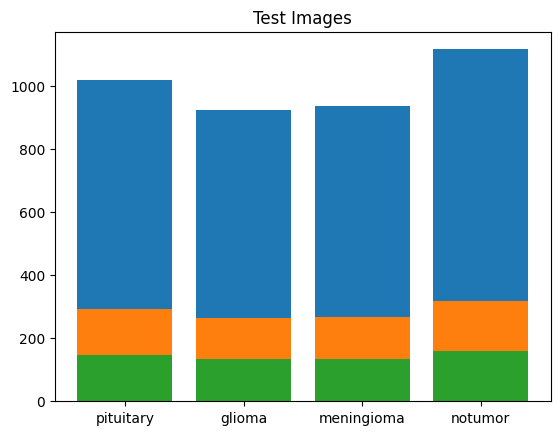

In [100]:
plot_catg_count(conf.train_dir, "Training Images")
plot_catg_count(conf.val_dir, "Validation Images")
plot_catg_count(conf.test_dir, "Test Images")

# **Transfer learning on Inception V3**

# **Making my own model**

In [178]:
class MakeModel:
    def __init__(self, model_inp_shape, filters=[32,64,128,192,192,256,256],kernel_size=3, dense_units=[16, 8]):
        self.input_shape = model_inp_shape
        
        self.input = Input(shape=self.input_shape)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dense_units = dense_units
        self.base_learning_rate = 0.0001
        
        self.conv_layers = []
        self.dense_layers = []
        self.max_pools = []
        self.batch_norms = []
        self.conv_acti = []
        self.output_layer = layers.Dense(4, activation="softmax", name="output_layer")
        
        self.data_augmentation = Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomFlip('vertical'),
            layers.RandomRotation(0.2),
        ])
        
        
    def build_layers(self):
        for idx, filter_size in enumerate(self.filters):
            self.conv_layers.append(layers.Conv2D(filter_size, kernel_size=self.kernel_size, name=f"conv_{idx}"))

        for idx, _ in enumerate(self.filters):
            self.batch_norms.append(layers.BatchNormalization(name=f"batch_norm_{idx}"))  
            self.max_pools.append(layers.MaxPooling2D((2, 2), name=f"max_pool_{idx}"))
            self.conv_acti.append(layers.Activation("relu", name=f"activation_{idx}"))

        for idx, d_c in enumerate(self.dense_units):
            self.dense_layers.append(layers.Dense(d_c, activation="relu", name=f"dense_{idx}"))

    def make_model(self):
        self.build_layers()
        inputs = self.input

        # Adding Conv Layers
        for idx, conv_layer in enumerate(self.conv_layers):
            if idx == 0:
                x = conv_layer(inputs)
            else:
                x = conv_layer(x)
                
            # No pooling operation or normalization last layer.
            if idx < len(self.conv_layers) - 1:
                x = self.batch_norms[idx](x)
                x = self.max_pools[idx](x)
            x = self.conv_acti[idx](x)

        # Adding dense layers.
        x = layers.GlobalAveragePooling2D(name="gap_0")(x)
        for idx, dense_layer in enumerate(self.dense_layers):
            x = dense_layer(x)
            x = layers.Dropout(0.2, name=f"dropout_{idx}")(x)

        outputs = self.output_layer(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs, name="brain-mri-cnn")


    def get_model(self):
        self.make_model()
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.base_learning_rate),
            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        
        return self.model

In [179]:
model_inp_shape = train_conf.img_shape + (3,)

model_maker = MakeModel(model_inp_shape)
model = model_maker.get_model()

In [180]:
model.summary()

Model: "brain-mri-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0 (Conv2D)                 │ (None, 382, 382, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_0                    │ (None, 382, 382, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_0 (MaxPooling2D)       │ (None, 191, 191, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_0 (Activation)       │ (None, 191, 191, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 189, 189, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 189, 189, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling2D)       │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 92, 92, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 92, 92, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2 (MaxPooling2D)       │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 44, 44, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 44, 44, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_3 (MaxPooling2D)       │ (None, 22, 22, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 22, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 20, 20, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 20, 20, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_4 (MaxPooling2D)       │ (None, 10, 10, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 10, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 256)      │       442,624 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,687,036 (6.44 MB)

 Trainable params: 1,685,308 (6.43 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [186]:
callbacks = keras.callbacks.ModelCheckpoint(
    "brain_mri_4_catg.keras",
    save_best_only=True,
)
callbacks = [callbacks]

# Training the model
history = model.fit(train_set, epochs=train_conf.epochs, validation_data=val_set, callbacks=callbacks)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.4407 - loss: 1.2087 - val_accuracy: 0.2747 - val_loss: 1.3571
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6535 - loss: 0.9348 - val_accuracy: 0.4226 - val_loss: 1.1977
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.7313 - loss: 0.8214 - val_accuracy: 0.5818 - val_loss: 1.0592
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.7523 - loss: 0.7853 - val_accuracy: 0.7830 - val_loss: 0.7325
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.7910 - loss: 0.6966 - val_accuracy: 0.5381 - val_loss: 1.2100
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.8059 - loss: 0.6615 - val_accuracy: 0.8206 - val_loss: 0.6107
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.8086 - loss: 0.6580 - val_accuracy: 0.8198 - val_loss: 0.6572
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.7979 - loss: 0

In [188]:
# Save the weights
checkpoint_path = "/kaggle/working/brain_mri__4catg-{epoch:04d}.weights.h5"
model.save_weights(checkpoint_path.format(epoch=0))

# **GradCAM**

In [223]:
def grad_cam(model, image, class_index):
    """
        TODO: 
            1. Fetch the last conv layer and making a model with the last conv as output.
            2. 
    """
    last_conv_layer = model.get_layer("activation_6")
    last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)
    
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in ['gap_0', 'dense_0', 'dense_1']:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.clip(heatmap, 0, np.max(heatmap)) / np.max(heatmap)
    heatmap = cv2.resize(heatmap, train_conf.img_shape)
    
    return heatmap

In [245]:
sample_image = None
sample_target = None
for i in test_set:
    sample_image = i[0][0]
    sample_target = i[1][0]
    break

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([[5.7850108e-03 4.8803155e-05 3.0078054e-03 9.9115843e-01]], shape=(1, 4), dtype=float32)


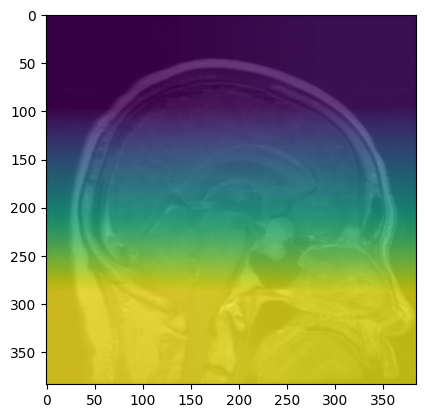

In [246]:
heatmap = grad_cam(model, sample_image, 1)   

plt.imshow(sample_image / 255)
plt.imshow(heatmap, alpha=0.8)
print(sample_target)
print(model(np.expand_dims(sample_image, axis=0)))